In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from PIL import Image
import pytorch_lightning as pl
import albumentations as A
import pandas as pd
from pytorch_lightning.callbacks import RichProgressBar
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from model_multiclass import *

train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


df = pd.read_csv('annotations_train_tcga.csv')
train_dataset = CustomDataset('./images/', df, transform=train_transform)

df_val = pd.read_csv('annotations_val.csv')
val_dataset = CustomDataset('./images/', df_val, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=8, num_workers=7, persistent_workers=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, num_workers=7, persistent_workers=True, shuffle=False)

from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project="QUILTCleaner")

model = CNN(num_classes=8)
trainer = pl.Trainer(accelerator='cuda', logger=wandb_logger, max_epochs=100, callbacks=[RichProgressBar(), EarlyStopping(monitor="val_loss", patience=10, mode="min")])
trainer.fit(model, train_loader, val_loader)


Epoch 16/99 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831/831 0:00:20 • 0:00:00 41.21it/s v_num: w4ot

 19%|████████████████████▍                                                                                    | 12587/64669 [02:36<10:18, 84.21it/s]

# Validation

In [2]:
from torchmetrics import Recall, Specificity, Accuracy

from tqdm import tqdm 

recall = Recall(task="multilabel", average="none", num_labels=8)
specificity = Specificity(task="multilabel", average="none", num_labels=8)
accuracy = Accuracy(task="multilabel", average="none", num_labels=8)
with torch.no_grad():
    for data in tqdm(val_loader):
        y_pred = model(data[0])
        recall.update(y_pred, data[1])
        specificity.update(y_pred, data[1])
        accuracy.update(y_pred, data[1])
        
print(recall.compute())
print(specificity.compute())
print(accuracy.compute())



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [01:06<00:00,  1.47it/s]

tensor([0.9375, 0.9513, 0.8254, 0.6667, 0.7042, 0.8889, 0.9100, 0.7183])
tensor([0.9851, 0.9873, 0.9519, 0.9735, 0.9890, 0.9953, 0.9522, 0.9945])
tensor([0.9765, 0.9745, 0.9194, 0.9388, 0.9684, 0.9806, 0.9388, 0.9745])


# Test 

In [3]:
df_test = pd.read_csv('annotations_test.csv')


test_dataset = CustomDataset('./images/', df_test, transform=test_transform)

test_loader = DataLoader(test_dataset, batch_size=10, num_workers=7, persistent_workers=True, shuffle=False)


In [4]:

from torchmetrics import AUROC

recall = Recall(task="multilabel", average="none", num_labels=8)
auroc = AUROC(task="multilabel", average="none", num_labels=8)
accuracy = Accuracy(task="multilabel", average="none", num_labels=8)
specificity = Specificity(task="multilabel", average="none", num_labels=8)
recall_any = Recall(task="binary")
auroc_any = AUROC(task="binary")
accuracy_any = Accuracy(task="binary")
specificity_any = Specificity(task="binary")

with torch.no_grad():
    for data in tqdm(test_loader):
        y_pred = model(data[0].cuda()).cpu()
        recall.update(y_pred, data[1])
        specificity.update(y_pred, data[1])
        accuracy.update(y_pred, data[1])
        auroc.update(y_pred, data[1].int())
        recall_any.update(y_pred.max(1).values, data[1].max(1).values)
        auroc_any.update(y_pred.max(1).values, data[1].max(1).values)
        accuracy_any.update(y_pred.max(1).values, data[1].max(1).values)
        specificity_any.update(y_pred.max(1).values, data[1].max(1).values)
        
print(recall.compute())
print(specificity.compute())
print(accuracy.compute())
print(auroc.compute())

print(recall_any.compute())
print(auroc_any.compute())
print(accuracy_any.compute())
print(specificity_any.compute())



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 30.29it/s]

tensor([0.9659, 0.9576, 0.8577, 0.6348, 0.7255, 0.8819, 0.8907, 0.6750])
tensor([0.9897, 0.9888, 0.9607, 0.9618, 0.9806, 0.9883, 0.9581, 0.9933])
tensor([0.9847, 0.9776, 0.9327, 0.9235, 0.9673, 0.9745, 0.9367, 0.9673])
tensor([0.9962, 0.9897, 0.9683, 0.9108, 0.9489, 0.9840, 0.9733, 0.9717])
tensor(0.9271)
tensor(0.9717)
tensor(0.9316)
tensor(0.9481)


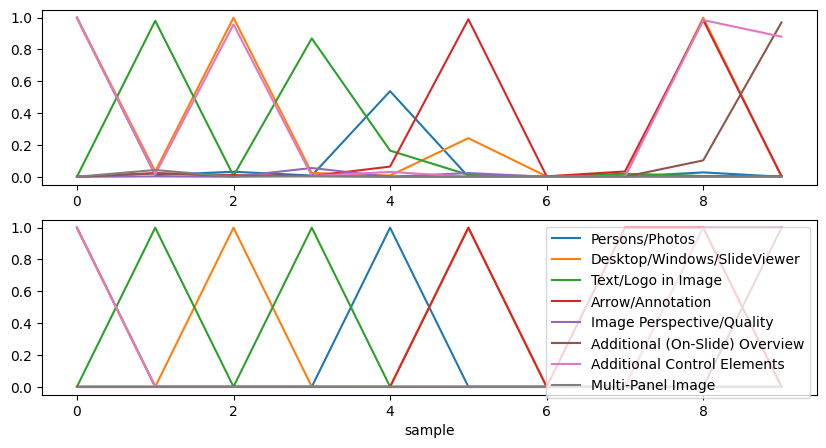

In [5]:
import matplotlib.pyplot as plt
classes = ['Persons/Photos', 'Desktop/Windows/SlideViewer','Text/Logo in Image','Arrow/Annotation','Image Perspective/Quality', 'Additional (On-Slide) Overview', 'Additional Control Elements', 'Multi-Panel Image']

fig,ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(y_pred)
ax[1].plot(data[1])
plt.xlabel('sample')
plt.legend(classes)

# Inference on remainder of dataset

In [6]:
all_quilt = os.listdir('/data/patho/text2image/QUILT_1M/quilt_1m')
all_quilt = [x for x in all_quilt if '.csv' not in x]
df_all = [x.split('/')[-1] for x in pd.read_csv('annotations.csv').Image.to_numpy()]

not_used = [x for x in all_quilt if x not in df_all]


In [7]:
df_unused = pd.DataFrame({'Image': not_used})

In [8]:

df_unused['Class 1']=0
df_unused['Class 2']=0
df_unused['Class 3']=0
df_unused['Class 4']=0
df_unused['Class 6']=0
df_unused['Class 7']=0
df_unused['Class 8']=0
df_unused['Class 9']=0

In [9]:
unused_dataset = CustomDataset('/data/patho/text2image/QUILT_1M/quilt_1m/', df_unused, transform=test_transform)

unused_loader = DataLoader(unused_dataset, batch_size=10, num_workers=7, persistent_workers=True, shuffle=False)


In [10]:
results=[]
with torch.no_grad():
    model = model.cuda()
    for data in tqdm(unused_loader):
        y_pred = model(data[0].cuda())
        results += y_pred.data

 19%|████████████████████▍                                                                                    | 12587/64669 [02:26<10:18, 84.21it/s]IOStream.flush timed out
IOStream.flush timed out
 52%|██████████████████████████████████████████████████████▌                                                  | 33605/64669 [07:06<06:26, 80.33it/s]/home/marc/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 64669/64669 [13:09<00:00, 81.86it/s]


In [11]:
torch.save(CNN, 'QuiltCLEANER_ResNet50d.pth')

In [12]:
res = torch.vstack(results)

In [13]:
torch.save(res, 'prediction_tcgaaugmented_quilt_1m.pth')

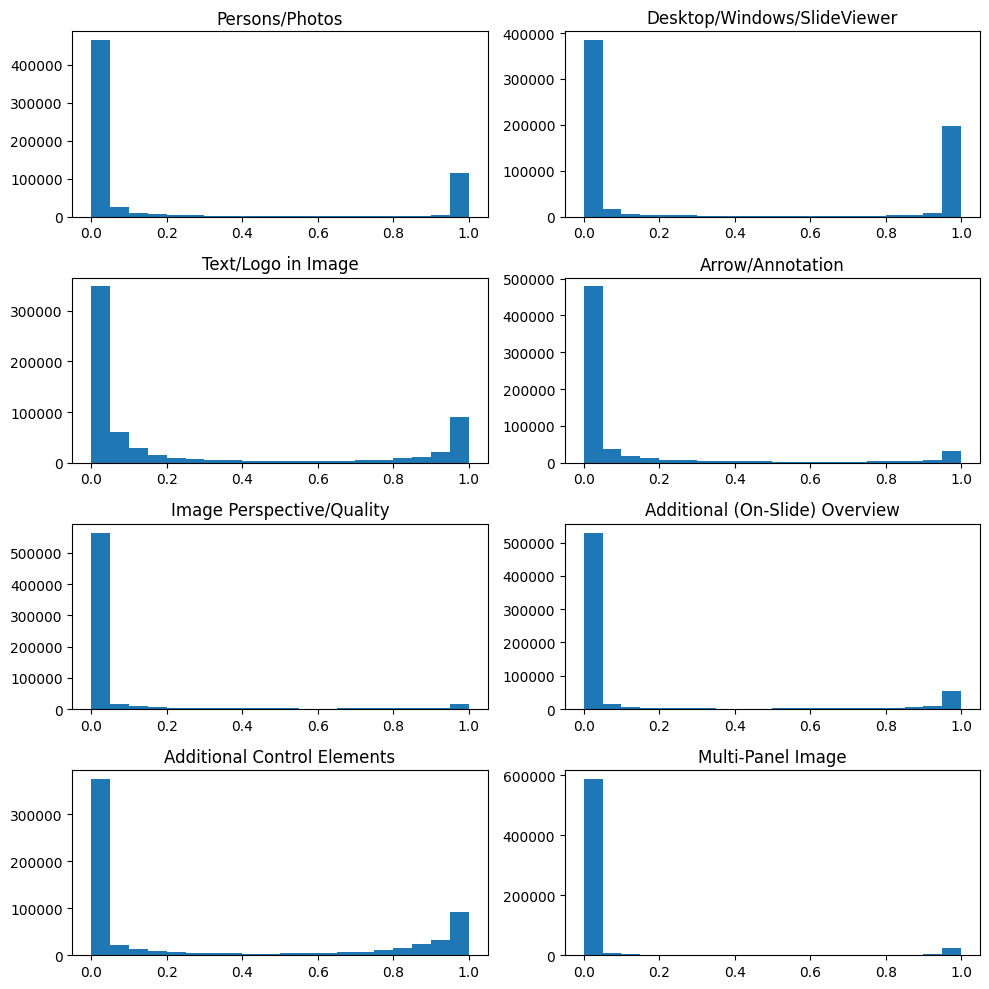

In [14]:
fig,ax=plt.subplots(4,2,figsize=(10,10))
ax=ax.flatten()
for i,c in enumerate(classes):
    ax[i].hist(res[:,i].cpu(),bins=20)
    ax[i].set_title(c)
plt.tight_layout()

Text(0.5, 1.0, 'any impurity')

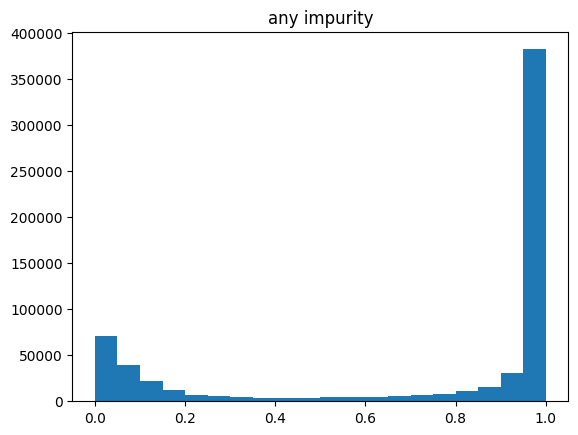

In [15]:
anyimp = torch.max(res.cpu(),1).values
plt.hist(anyimp,20)
plt.title('any impurity')

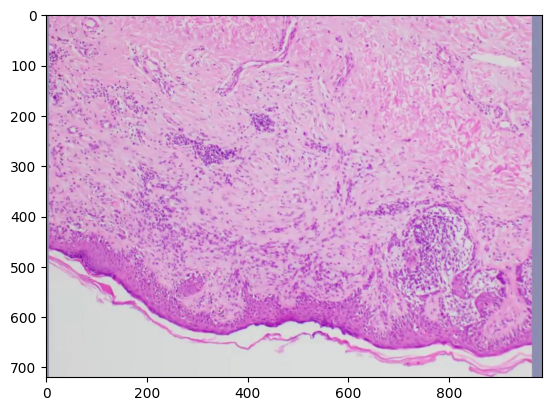

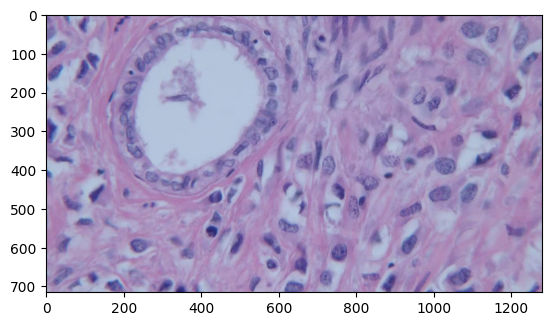

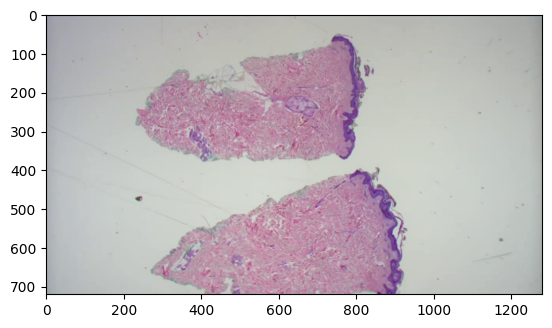

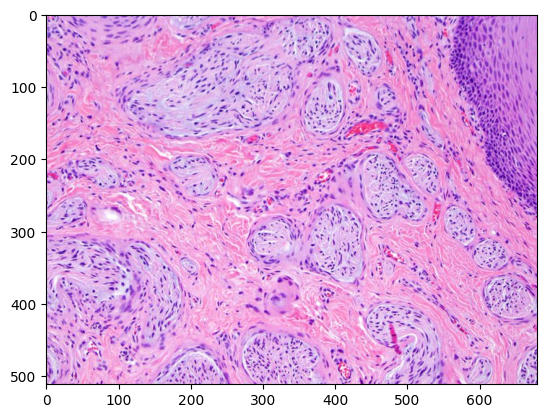

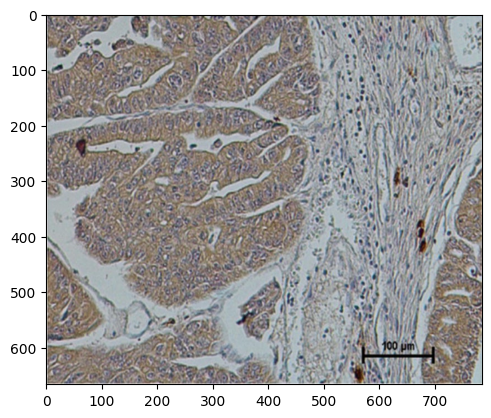

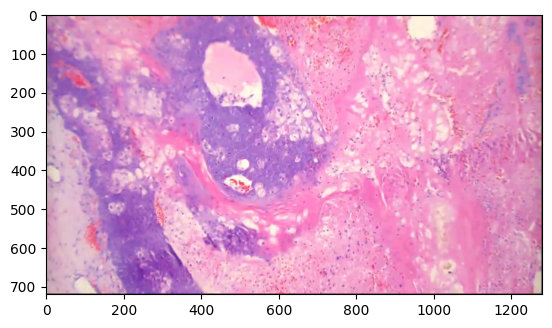

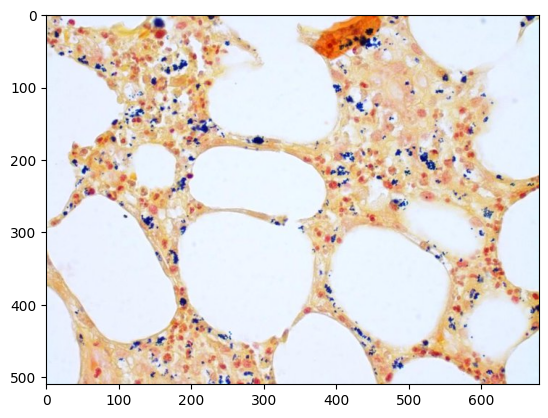

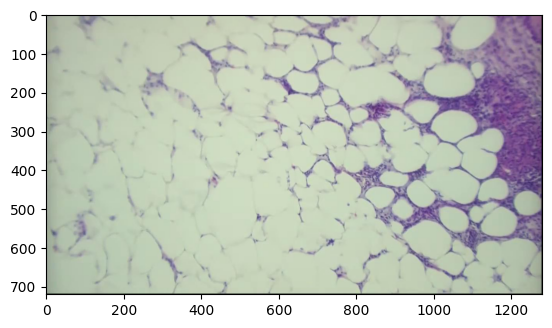

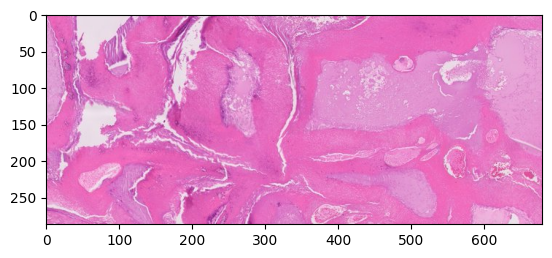

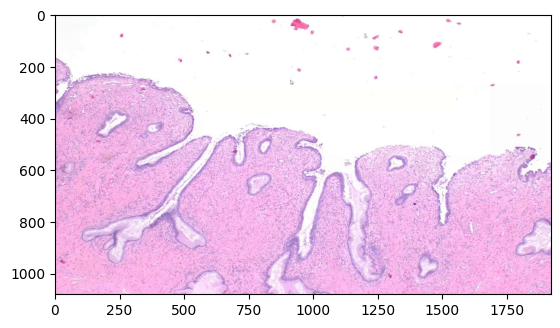

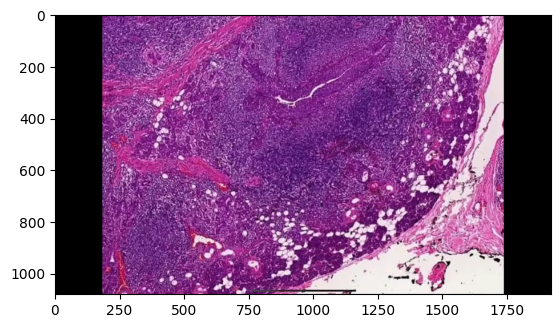

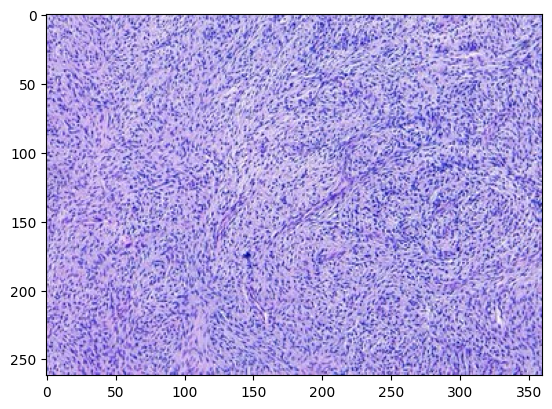

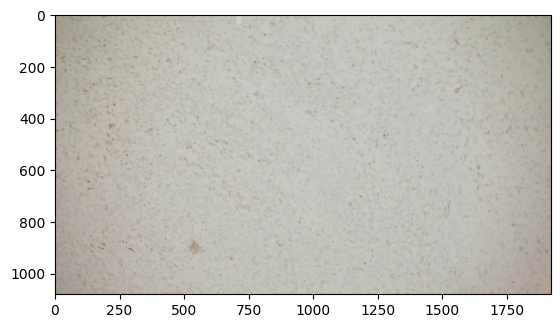

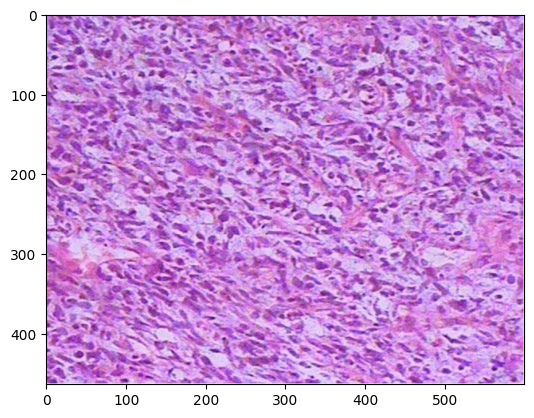

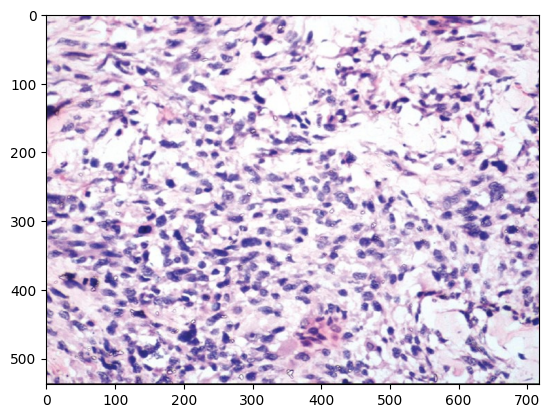

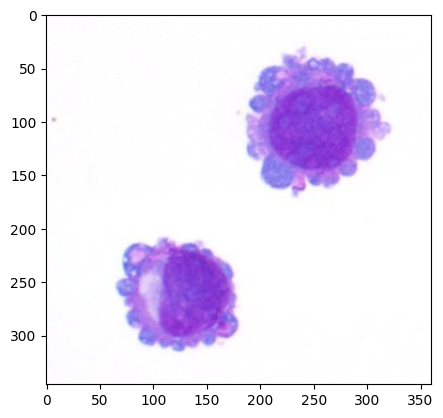

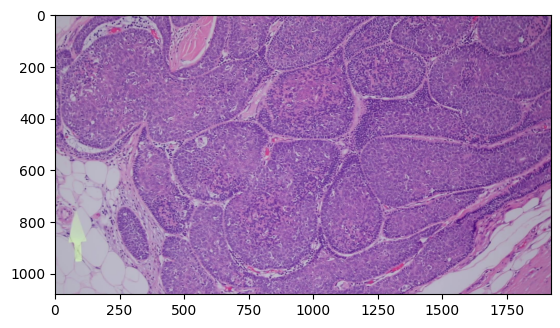

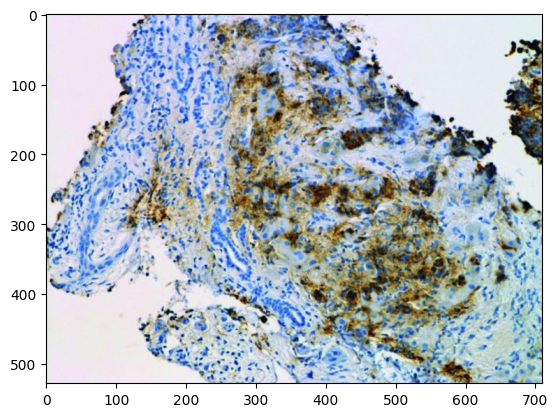

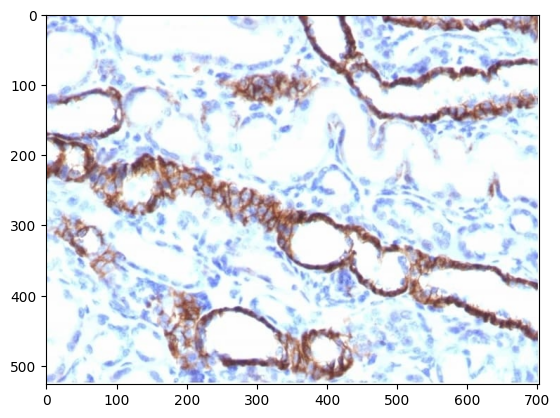

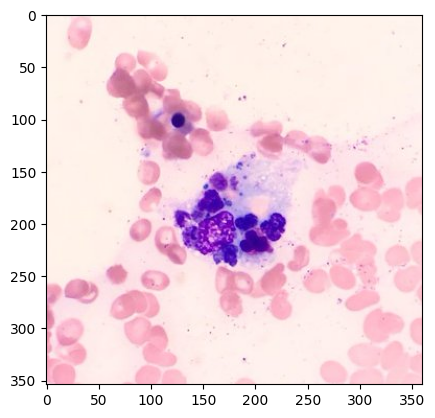

In [16]:
from PIL import Image
sel = anyimp<0.05
for k in np.array(not_used)[sel][0:20]:
    i = Image.open('/data/patho/text2image/QUILT_1M/quilt_1m/'+k)
    plt.figure()
    plt.imshow(i)

In [17]:
all_predictions = []
for pred, anyimpairment, imgname in zip(res.cpu().numpy(), anyimp, not_used):
    all_predictions.append([*pred, anyimpairment.tolist(), imgname])

In [18]:
df_infer = pd.DataFrame(all_predictions, columns=classes+['Any impairment','Filename'])

In [19]:
df_infer.head()

Persons/Photos  Desktop/Windows/SlideViewer  Text/Logo in Image  \
0        0.000035                     0.000176            0.003073   
1        0.001079                     0.000428            0.793025   
2        0.175576                     0.996286            0.018881   
3        0.015089                     0.009346            0.994760   
4        0.000820                     0.003187            0.061632   

   Arrow/Annotation  Image Perspective/Quality  \
0          0.012374               3.473922e-01   
1          0.002011               9.654037e-07   
2          0.678668               8.437134e-05   
3          0.062458               1.622094e-03   
4          0.188072               2.158552e-02   

   Additional (On-Slide) Overview  Additional Control Elements  \
0                    5.010892e-07                     0.000020   
1                    2.067552e-03                     0.017278   
2                    9.340526e-01                     0.972967   
3                    5.420902e-05                     0.000065   
4                    2.024994e-04                     0.000390   

   Multi-Panel Image  Any impairment  \
0           0.000008        0.347392   
1           0.000066        0.793025   
2           0.000038        0.996286   
3           0.985079        0.994760   
4           0.001751        0.188072   

                                            Filename  
0  47qbh9YVaxI_image_0bdbb2f0-3064-4475-bd98-0ab1...  
1                          1316262983740219392_1.jpg  
2  5PjDcGH2okQ_image_45664371-1a34-45c4-bf4e-7319...  
3  3awkLNUybLc_image_5b5c9a32-7ebe-4277-b669-0dac...  
4                           961459302123782144_0.jpg

In [20]:
df_infer.to_csv('predictions_quiltcleaner.csv')